In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (18, 4)

In [2]:
!gdown 10th1MQc6z1no6BzG03HiCc4xKiyOVD_v
!gdown 1N69keuZMDpcLXxTMvJ6YtqFZNqT1kQkB
!gdown 1SLVu-veHWFggWbbgCwJOD-7oIsyszcEB

Downloading...
From: https://drive.google.com/uc?id=10th1MQc6z1no6BzG03HiCc4xKiyOVD_v
To: /Users/architsharma/scaler_dsml/ML2 Practical_Interview/product_hierarchy.parquet
100%|██████████████████████████████████████| 22.2k/22.2k [00:00<00:00, 35.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N69keuZMDpcLXxTMvJ6YtqFZNqT1kQkB
To: /Users/architsharma/scaler_dsml/ML2 Practical_Interview/sales.parquet
100%|██████████████████████████████████████| 52.0M/52.0M [00:02<00:00, 24.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SLVu-veHWFggWbbgCwJOD-7oIsyszcEB
To: /Users/architsharma/scaler_dsml/ML2 Practical_Interview/store_cities.parquet
100%|██████████████████████████████████████| 4.80k/4.80k [00:00<00:00, 6.57MB/s]


In [3]:
from prophet import Prophet

In [4]:
sales   = pd.read_parquet('sales.parquet')
stores  = pd.read_parquet('store_cities.parquet')
product = pd.read_parquet('product_hierarchy.parquet')

In [5]:
sales.head()

product_id store_id       date  sales  revenue  stock  price promo_type_1  \
0      P0001    S0002 2017-01-02    0.0     0.00    8.0   6.25         PR14   
1      P0001    S0012 2017-01-02    1.0     5.30    0.0   6.25         PR14   
2      P0001    S0013 2017-01-02    2.0    10.59    0.0   6.25         PR14   
3      P0001    S0023 2017-01-02    0.0     0.00    6.0   6.25         PR14   
4      P0001    S0025 2017-01-02    0.0     0.00    1.0   6.25         PR14   

  promo_bin_1 promo_type_2 promo_bin_2  promo_discount_2 promo_discount_type_2  
0        None         PR03        None               NaN                  None  
1        None         PR03        None               NaN                  None  
2        None         PR03        None               NaN                  None  
3        None         PR03        None               NaN                  None  
4        None         PR03        None               NaN                  None

In [6]:
stores.head()

store_id storetype_id  store_size city_id
0    S0091         ST04          19    C013
1    S0012         ST04          28    C005
2    S0045         ST04          17    C008
3    S0032         ST03          14    C019
4    S0027         ST04          24    C022

In [7]:
product.head()

product_id  product_length  product_depth  product_width cluster_id  \
0      P0000             5.0           20.0           12.0       None   
1      P0001            13.5           22.0           20.0  cluster_5   
2      P0002            22.0           40.0           22.0  cluster_0   
3      P0004             2.0           13.0            4.0  cluster_3   
4      P0005            16.0           30.0           16.0  cluster_9   

  hierarchy1_id hierarchy2_id hierarchy3_id hierarchy4_id hierarchy5_id  
0           H00         H0004       H000401     H00040105   H0004010534  
1           H01         H0105       H010501     H01050100   H0105010006  
2           H03         H0315       H031508     H03150800   H0315080028  
3           H03         H0314       H031405     H03140500   H0314050003  
4           H03         H0312       H031211     H03121109   H0312110917

In [12]:
sales.shape

(19454838, 13)

In [13]:
print(sales.shape)
sales = sales.merge(product[['product_id', 'hierarchy1_id']])
sales = sales.loc[sales['hierarchy1_id'].isin(['H00', 'H02'])]
sales = sales.merge(stores[['store_id', 'city_id']])
selected_cities = list(sales['city_id'].value_counts(normalize=True)[:10].index)
sales = sales.loc[sales['city_id'].isin(selected_cities)]
sales = sales[['product_id', 'store_id', 'date', 'sales']]
print(sales.shape)

(19454838, 13)
(6519823, 4)


In [14]:
sales.head()

product_id store_id       date  sales
0      P0015    S0001 2017-01-02    1.0
1      P0015    S0001 2017-01-03    0.0
2      P0015    S0001 2017-01-04    0.0
3      P0015    S0001 2017-01-05    0.0
4      P0015    S0001 2017-01-06    5.0

In [15]:
dates = sales[['date']].drop_duplicates(['date'])
ids = sales[['store_id', 'product_id']].drop_duplicates()
dates['key'], ids['key'] = 1, 1
frame = ids.merge(dates, how='outer').drop(columns=['key'])
sales = frame.merge(sales, how='outer').fillna(0)
print(sales.shape)

(10923276, 4)


In [16]:
def fltr(data, product=None, store=None):
    if product and not store:
        return data.loc[(data.product_id == product)]
    if store and not product:
        return data.loc[(data.store_id == store)]
    return data.loc[(data.product_id == product) & (data.store_id == store)]

def plot(data, name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data))
    fig.update_layout(title=name)
    return fig

def plots(data, title):
    f = go.Figure()
    for d, name in data:
        f.add_trace(go.Scatter(x=d.index, y=d, name=name))
    f.update_layout(title=title)
    return f


def plot_group(data, col):
    return plots([(sales.loc[sales[col] == g].groupby('date')['sales'].sum(), g) for g in sales[col].unique()], title=f'By {col}')

        
def show_group(data, grp):
    if grp is None:
        grp = [1]*len(data)
    x = data.groupby(grp).agg({'sales':['count', 'sum'], 'tsid':'nunique'}).reset_index()
    x.columns = [grp, '# points', 'sales', '# ts']
    for col in x.columns[1:]:
        x[col] = round(x[col]/x[col].sum(), 2)
    x = x.sort_values(by='# points', ascending=False)
    return x

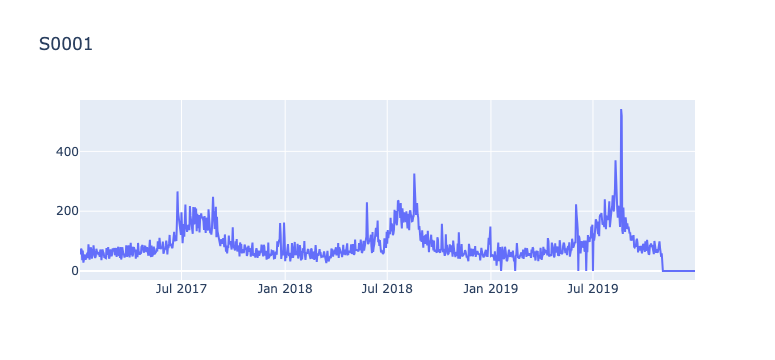

In [17]:
plot(fltr(sales, None, 'S0001').groupby('date')['sales'].sum(), name='S0001')

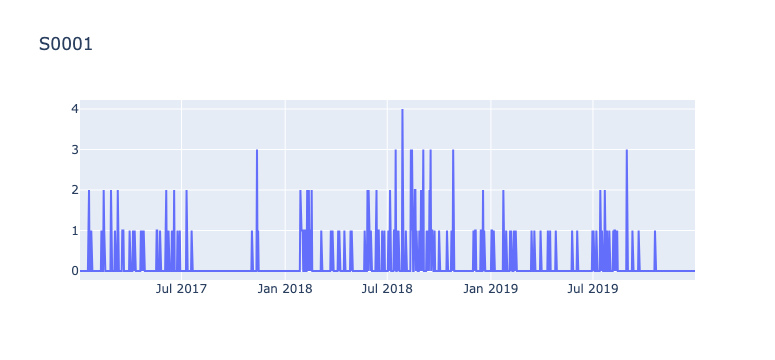

In [22]:
plot(fltr(sales, 'P0018', 'S0001').groupby('date')['sales'].sum(), name='S0001')

In [23]:
s0001 = fltr(sales, None, 'S0001')
animation = pd.DataFrame()
p = list(s0001.product_id.unique())
p1 = p.pop(2)
p = [p1] + p
for i in range(len(p)):
    d = s0001.loc[s0001.product_id.isin(p[:i])].groupby('date')['sales'].mean().reset_index()
    d['num_products'] = i
    animation = animation.append(d)
animation = animation.loc[animation.num_products.isin(list(range(11)) + [30, 40, 50, 100, 150, 154])]

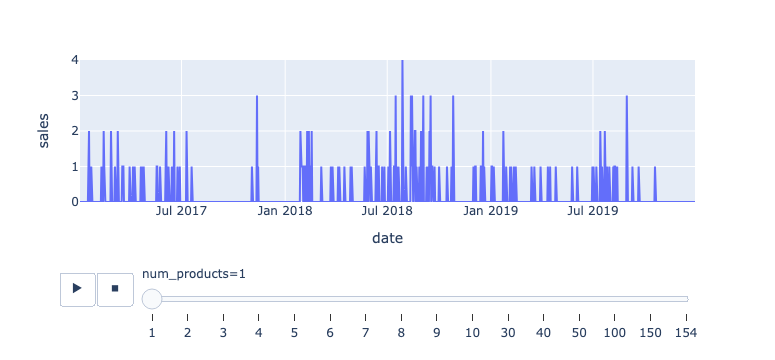

In [24]:
fig = px.line(animation, x="date", y="sales", animation_frame="num_products", range_y=[0,4])
fig.show()

/Users/architsharma/miniconda3/envs/tf/lib/python3.9/site-packages/pandas/util/_decorators.py:211: EstimationWarning:

Model has no free parameters to estimate. Set optimized=False to suppress this warning



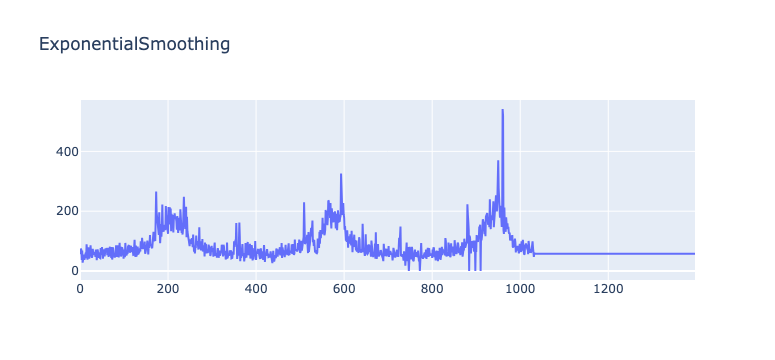

In [25]:
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
data = fltr(sales.loc[sales.date <= '2019-10-31'], None, 'S0001').groupby('date')['sales'].sum().values
fit = SimpleExpSmoothing(data, initialization_method="heuristic").fit(smoothing_level=0.8, optimized=True)
fcast = fit.forecast(365)
pred = pd.Series(np.append(data, fcast))
plot(pred, name='ExponentialSmoothing')

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(data ,order=(3,1,2), seasonal_order=(1, 0, 0, 12))
result=model.fit()
pred = result.predict(start=0, end=len(data) + 365)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94952D+00    |proj g|=  3.63851D-01

At iterate    5    f=  4.78134D+00    |proj g|=  2.09003D-02


 This problem is unconstrained.



At iterate   10    f=  4.78086D+00    |proj g|=  1.03039D-03

At iterate   15    f=  4.78046D+00    |proj g|=  4.88883D-03

At iterate   20    f=  4.78040D+00    |proj g|=  3.59374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     28      1     0     0   6.326D-05   4.780D+00
  F =   4.7804015779856357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<Axes: >

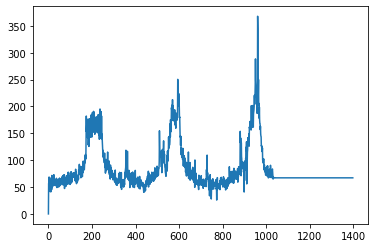

In [27]:
pd.Series(pred).plot()

Initial log joint probability = -8.76791
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2552.6   1.05891e-05       77.5133      0.6066      0.6066      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       2552.62    5.6551e-05       74.6206   6.552e-07       0.001      248  LS failed, Hessian reset 
     199       2552.62   3.87246e-07       50.7679      0.5634      0.5634      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       2552.62   3.72911e-07       67.4436      0.2866           1      349   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


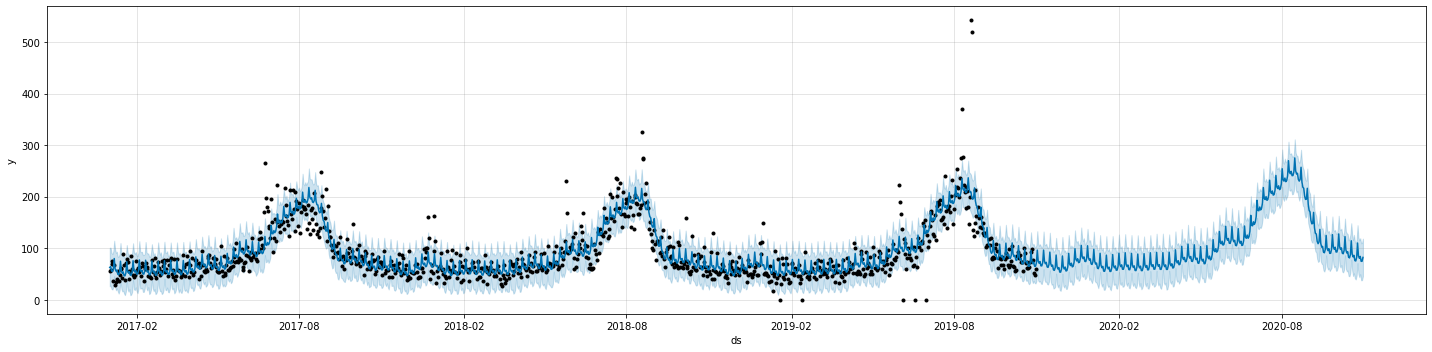

In [28]:
from prophet import Prophet
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative')
data = fltr(sales, None, 'S0001').groupby('date')['sales'].sum().reset_index()
data = data.loc[data.date <= '2019-10-31']
data.columns = ['ds', 'y']
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(20,5))

Initial log joint probability = -11.0312
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       1671.97    0.00195879       112.848   2.115e-05       0.001      109  LS failed, Hessian reset 
      99       1672.25   0.000332198       71.2191      0.8272      0.8272      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1672.89    0.00110464       98.6279      0.5809      0.5809      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       1673.31     0.0024663       281.481   1.762e-05       0.001      405  LS failed, Hessian reset 
     299        1673.6   0.000191773       70.0298      0.1436           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1674.04    0.00234735       154.708      0.6289      0.6289      554   
    Iter      log pro

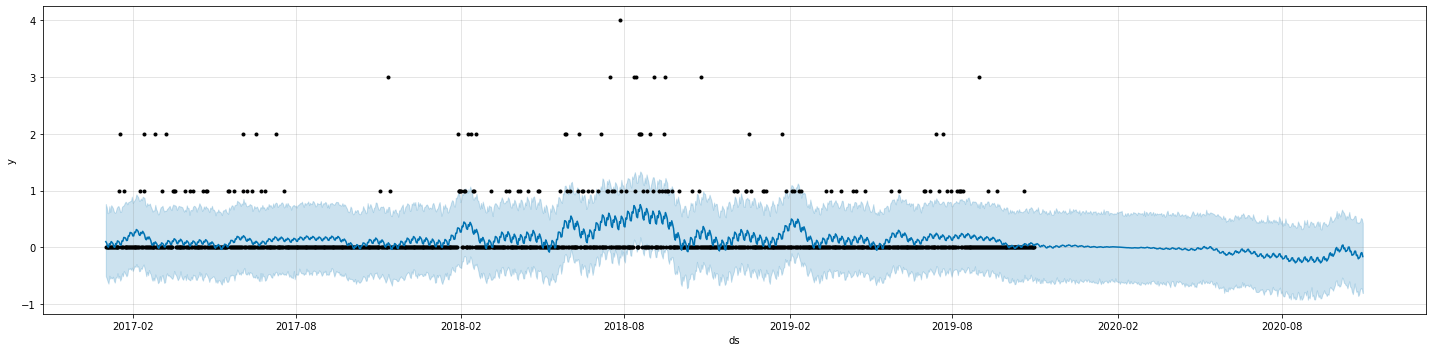

In [29]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative')
data = fltr(sales, 'P0018', 'S0001').groupby('date')['sales'].sum().reset_index()
data = data.loc[data.date <= '2019-10-31']
data.columns = ['ds', 'y']
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(20,5))

In [30]:
## Sparsity [imp]
## heirarchy [imp]
## scale [v imp]

### Scale

In [31]:
# of TS
# of features
# correlations :  between features & between timeseries
# frequnecy
# horizon

current data : 19.5M 
Stores: 144
Products: 699
Period 3y 
Size in memory: 2 GB





rows: 12-B
10-15 years of data
240 GB in memory

In [32]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10923276 entries, 0 to 10923275
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   store_id    object        
 1   product_id  object        
 2   date        datetime64[ns]
 3   sales       float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 416.7+ MB


In [33]:
sales = sales.merge(product).merge(stores)
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10923276 entries, 0 to 10923275
Data columns (total 16 columns):
 #   Column          Dtype         
---  ------          -----         
 0   store_id        object        
 1   product_id      object        
 2   date            datetime64[ns]
 3   sales           float64       
 4   product_length  float64       
 5   product_depth   float64       
 6   product_width   float64       
 7   cluster_id      object        
 8   hierarchy1_id   object        
 9   hierarchy2_id   object        
 10  hierarchy3_id   object        
 11  hierarchy4_id   object        
 12  hierarchy5_id   object        
 13  storetype_id    object        
 14  store_size      int64         
 15  city_id         object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(10)
memory usage: 1.4+ GB


In [34]:
for g1 in product.hierarchy1_id.unique()[:2]:
    print('- ' + g1)
    for g2 in product.loc[product.hierarchy1_id == g1].hierarchy2_id.unique()[:2]:
        print('    - ' + g2)
        for g3 in product.loc[product.hierarchy2_id == g2].hierarchy3_id.unique()[:2]:
            print('        - ' + g3)
            for g4 in product.loc[product.hierarchy3_id == g3].hierarchy4_id.unique()[:2]:
                print('            - ' + g4)

- H00
    - H0004
        - H000401
            - H00040105
            - H00040100
        - H000403
            - H00040305
            - H00040310
    - H0000
        - H000004
            - H00000400
            - H00000405
        - H000003
            - H00000309
            - H00000310
- H01
    - H0105
        - H010501
            - H01050100
            - H01050105
        - H010503
            - H01050309
            - H01050305
    - H0108
        - H010801
            - H01080109
            - H01080110
        - H010809
            - H01080900
            - H01080913


In [35]:
sales.loc[sales.sales > 5, 'sales'] = 5  # Removing Outliers
sales['tsid'] = sales['store_id'] + '|' + sales['product_id']
sales['tsid'].nunique()

10003

In [36]:
sales.shape[0]

10923276

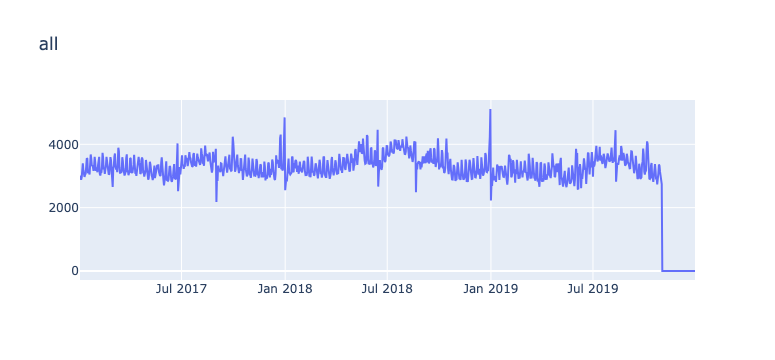

In [37]:
plot(sales.groupby('date')['sales'].sum(), name='all')

In [38]:
show_group(sales, 'hierarchy1_id')

hierarchy1_id  # points  sales  # ts
0           H00      0.98   0.99  0.98
1           H02      0.02   0.01  0.02

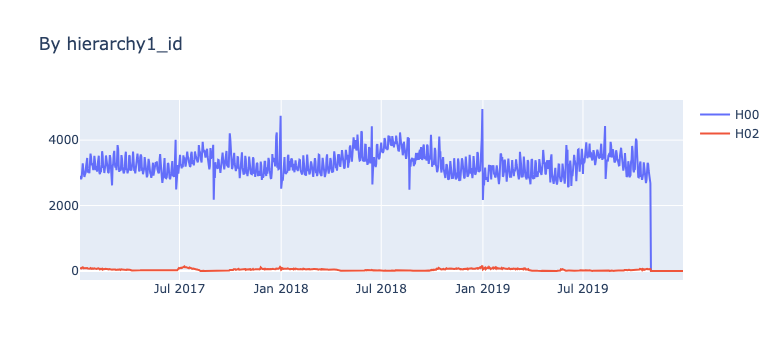

In [39]:
plot_group(sales, 'hierarchy1_id')

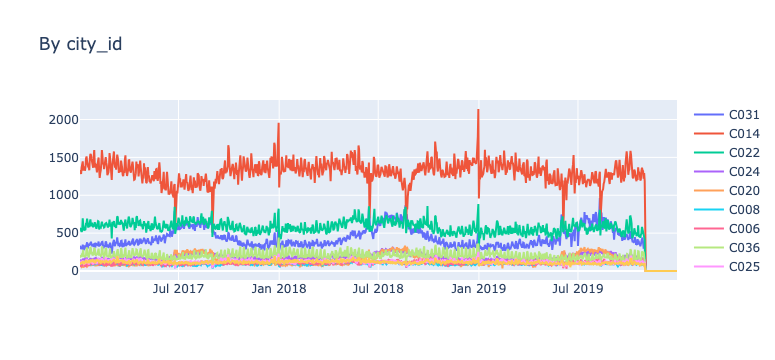

In [40]:
plot_group(sales, 'city_id')

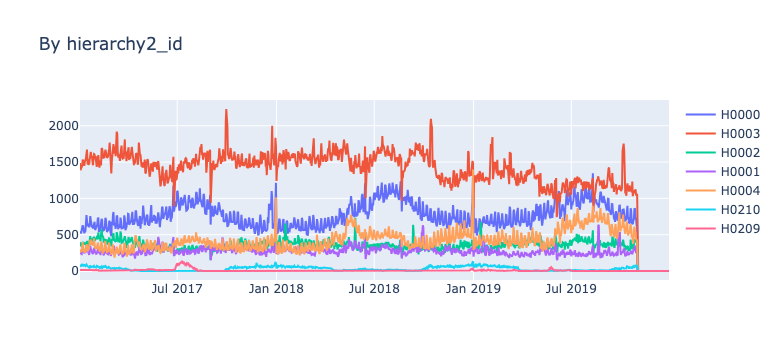

In [42]:
plot_group(sales, 'hierarchy2_id')

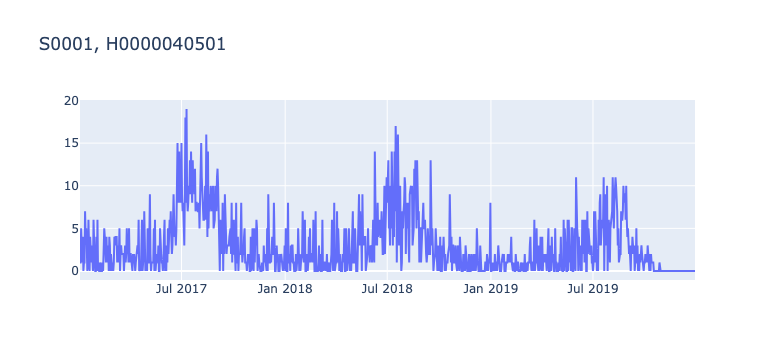

In [43]:
plot(sales.loc[(sales.store_id == 'S0001') & (sales.hierarchy5_id == 'H0000040501')].groupby('date')['sales'].sum(), name='S0001, H0000040501')

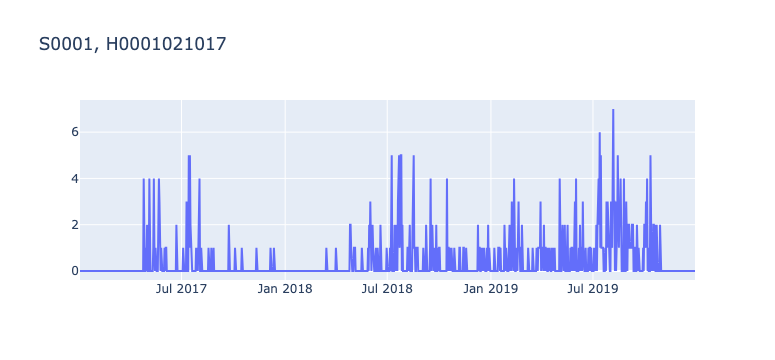

In [44]:
plot(sales.loc[(sales.store_id == 'S0001') & (sales.hierarchy5_id == 'H0001021017')].groupby('date')['sales'].sum(), name='S0001, H0001021017')

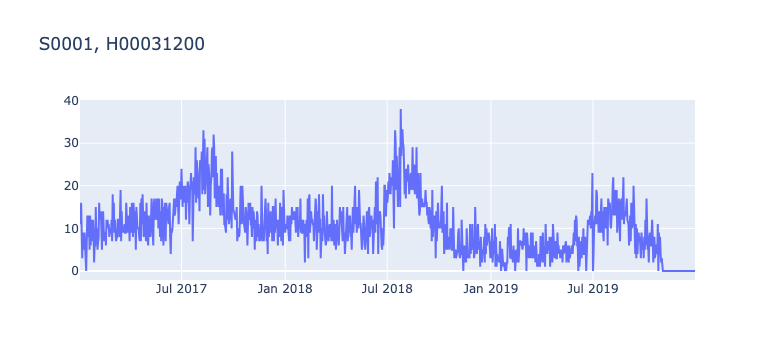

In [45]:
plot(sales.loc[(sales.store_id == 'S0001') & (sales.hierarchy4_id == 'H00031200')].groupby('date')['sales'].sum(), name='S0001, H00031200')

Initial log joint probability = -18.0099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1847.05      0.011667       355.019           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1857.36    0.00100934       234.441      0.6251     0.06251      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       1860.06   0.000305031       134.684   5.145e-06       0.001      360  LS failed, Hessian reset 
     299        1860.4     0.0025586        103.81      0.9008      0.9008      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       1861.08   0.000588114       356.843   6.889e-06       0.001      517  LS failed, Hessian reset 
     399       1861.51   1.26526e-05       64.2689      0.5409      0.5409      584   
    Iter      log pro

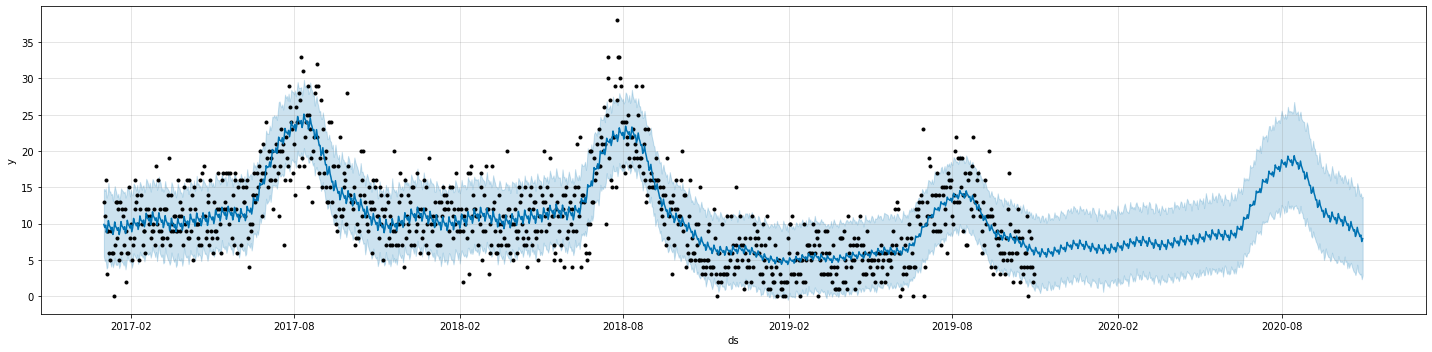

In [46]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative')
data = sales.loc[(sales.store_id == 'S0001') & (sales.hierarchy4_id == 'H00031200')].groupby('date')['sales'].sum().reset_index()
data = data.loc[data.date <= '2019-10-31']
data.columns = ['ds', 'y']
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(20,5))

In [47]:
ratios = sales.loc[(sales.store_id == 'S0001') & (sales.hierarchy4_id == 'H00031200')].groupby('hierarchy5_id')['sales'].sum().reset_index()
ratios['sales'] = ratios['sales'] / ratios['sales'].sum()
ratios.columns = ['hierarchy5_id', 'ratio']
ratios

hierarchy5_id     ratio
0   H0003120001  0.303816
1   H0003120002  0.190202
2   H0003120004  0.212645
3   H0003120012  0.156842
4   H0003120017  0.136495

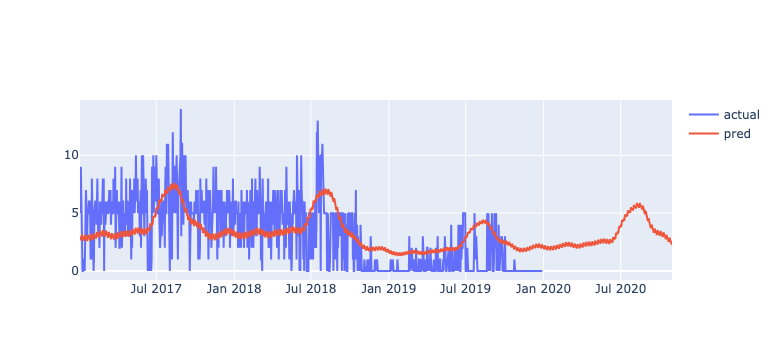

In [48]:
actual = sales.loc[(sales.store_id == 'S0001') & (sales.hierarchy4_id == 'H00031200') & (sales.hierarchy5_id == 'H0003120001')].groupby('date')['sales'].sum().reset_index()
pred = forecast[['ds', 'yhat']]
pred['yhat'] *= ratios.loc[ratios.hierarchy5_id == 'H0003120001'].ratio[0]
fig = go.Figure()
fig.add_trace(go.Scatter(x=actual.date, y=actual.sales, name='actual'))
fig.add_trace(go.Scatter(x=pred.ds, y=pred.yhat, name='pred'))

Initial log joint probability = -16.0487
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1498.12    0.00463565       244.564           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1512.56    0.00220368       178.591      0.8292      0.8292      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1514.28    5.4061e-05       69.1666      0.3087      0.3087      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       1516.51   0.000257205       272.558   2.917e-06       0.001      504  LS failed, Hessian reset 
     399       1517.21   0.000132807       89.8471           1           1      545   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     427       1517.34   5.97213e-05    

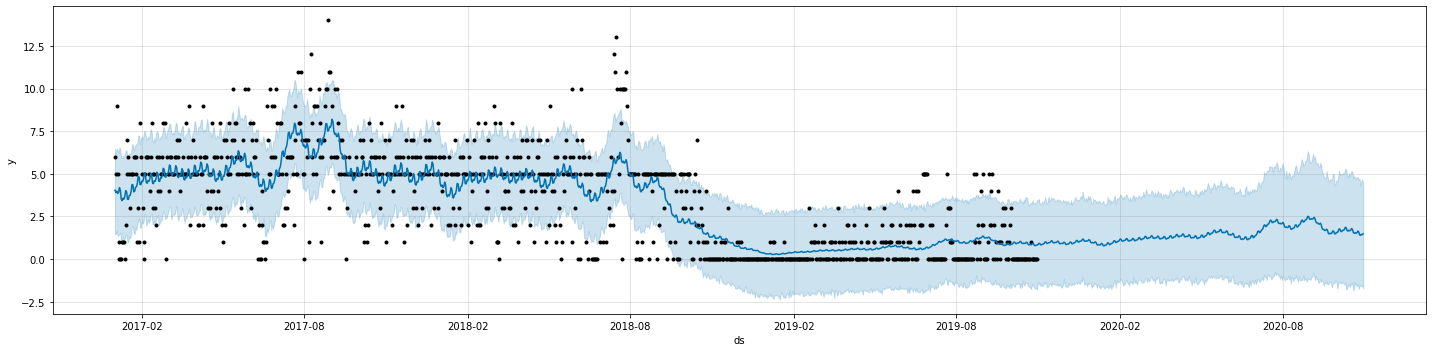

In [49]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative')
data = sales.loc[(sales.store_id == 'S0001') & (sales.hierarchy5_id == 'H0003120001')].groupby('date')['sales'].sum().reset_index()
data = data.loc[data.date <= '2019-10-31']
data.columns = ['ds', 'y']
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(20,5))